In [1]:
import os
import codecs
import re
import pickle
import numpy as np
import hmmlearn.hmm as hmm
import matplotlib.pyplot as plt
%matplotlib inline

# Reading data
## Basic reading

In [15]:
data_dir = 'data'  # basedir
lengthes = []  # length of paths
all_state = []  # all paths in a sequence
all_los = []  # los for each state in all_state
all_clusters = []
with codecs.open(os.path.join(data_dir, 'Clusters_with_durations.txt'), encoding='utf-8') as f:
    current_cluster = 0
    for line in f:
        if re.match(r'\[(.*)\]', line):
            states = [m.group(1) for m in re.finditer(r'\'([A-Z]*)\'', line)]
            duration = [int(m.group(1)) for m in re.finditer(r'[\s,]+([0-9]+)[,\]]+', line)]
            all_state.extend(states)
            all_los.extend(duration)
            lengthes.append(len(states))
            all_clusters.append(current_cluster)
        elif re.match(r'Cluster ([0-9]+)', line):
            current_cluster = int(re.match(r'Cluster ([0-9]+)', line).group(1))
lengthes = np.array(lengthes, dtype=int)
all_clusters = np.array(all_clusters, dtype=int)
lengthes, all_clusters

(array([7, 8, 9, ..., 8, 8, 8]), array([ 0,  0,  0, ..., 12, 12, 12]))

## Transform for further processing

In [3]:
# transforming to NP arrays
all_los = np.array(all_los, dtype=int)
all_state = np.array(all_state, dtype=str)
# building state dictionary and indexing
all_state_index = np.unique(all_state)
all_state_id = np.array(list(map(lambda a: np.where(all_state_index == a)[0][0], all_state)), dtype=int)
all_state_index

array(['A', 'D', 'E', 'F', 'I', 'N'],
      dtype='<U1')

In [4]:
# preparing mask showing CP starting positions in all_state
all_start_mask = [False]*len(all_state)
s_idx = 0
for l in lengthes:
    all_start_mask[s_idx] = True
    s_idx += l
all_start_mask[0:10]
all_start_mask = np.array(all_start_mask)
all_start_mask

array([ True, False, False, ..., False, False, False], dtype=bool)

In [5]:
# count transitions between states
transition_count = np.zeros((len(all_state_index), len(all_state_index)), dtype=int)
for i in range(1, len(all_state)):
    if not all_start_mask[i]:
        i1 = np.where(all_state_index == all_state[i-1])
        i2 = np.where(all_state_index == all_state[i])
        transition_count[i1, i2] += 1
transition_count

array([[   0,   18,   37, 2938,  255,  185],
       [   0,    0,  391,   30,    1,    1],
       [   0,  758,    0,  198,  153,   51],
       [   0,  279, 2950,    0, 1024, 1618],
       [   0,   17,  193, 2507,    0,   57],
       [   0,    2,   59,  480, 1361,    0]])

# Probability counting
## Future transfers
Counting probability of transfer to different states after the certain moment in time (T). Use simple Bayes: P(X|t>T)=P(t>T|X)*P(X)/P(t>T). Either counting (time-consuming) or loading data from pickle.

In [6]:
# ppp = []
# for i in range(len(all_state_index)):
#     print('Counting transfers from  {0}... '.format(all_state_index[i]))
#     dst = all_state_index[transition_count[i] > 0]
#     def get_los(src, dst):
#         mask = (all_state[:-1] == src) & (all_state[1:] == dst) & ~all_start_mask[1:]
#         return all_los[:-1][mask]
#     t_los = [np.array(get_los(all_state_index[i], d)) for d in dst]
#     t_range = np.linspace(1, max([max(dd) for dd in t_los]) - 1, 400)
#     all_cases = sum([len(ld) for ld in t_los])
#     p_x = [len(ld) / all_cases for ld in t_los]    
#     
#     def count_transition_prob(t, los_data, p_x, los_data_idx, all_cases):    
#         p_t_x = sum(los_data[los_data_idx] > t) / len(los_data[los_data_idx])
#         p_t = sum([sum(ld > t) for ld in los_data]) / all_cases
#         return p_t_x * p_x[los_data_idx] / p_t
#     
#     pp = []
#     for di in range(len(dst)):
#         p = [count_transition_prob(t, t_los, p_x, di, all_cases) for t in t_range]
#         pp.append(p)    
#     pp = np.array(pp)
#     ppp.append((all_state_index[i], dst, t_range, pp, t_los))
#     print('DONE')
# with open(os.path.join('data', 'transfer_time_and_probs.pkl'), 'wb') as f:
#     pickle.dump(ppp, f)
with open(os.path.join('data', 'transfer_time_and_probs.pkl'), 'rb') as f:
    ppp = pickle.load(f)
    print('Loaded from pickle')

Loaded from pickle


### Plotting transfer probability
Future transfer probability: where to go for t>T.

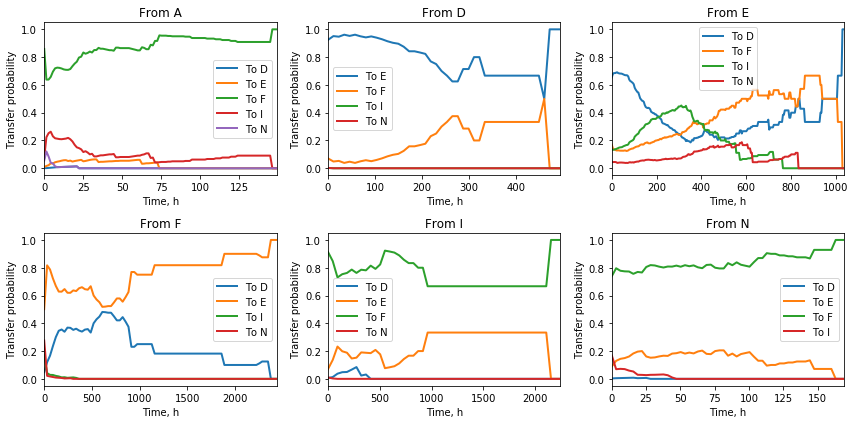

In [9]:
w, h = 4, 3
fig = plt.figure(figsize=(3*w, 2*h))
idx = 0
lims = []
for src, dst, t_range, pp, t_los in ppp:
    plt.subplot('23{0}'.format(idx + 1))
    for di in range(len(dst)):
        plt.plot(t_range / 60, pp[di], label='To ' + dst[di], linewidth=2)
    lims.append(t_range[min(np.max(np.where(pp.max(axis=0) < 0.9999)) + 3, len(t_range) - 1)])
    plt.xlim((0, lims[-1] / 60))
    plt.legend()
    plt.title('From {0}'.format(all_state_index[idx]))
    plt.xlabel('Time, h')
    plt.ylabel('Transfer probability')
    idx += 1
plt.tight_layout()
fig.patch.set_facecolor('white')

### LoS distribution
Staying in state depending on the transition destination.

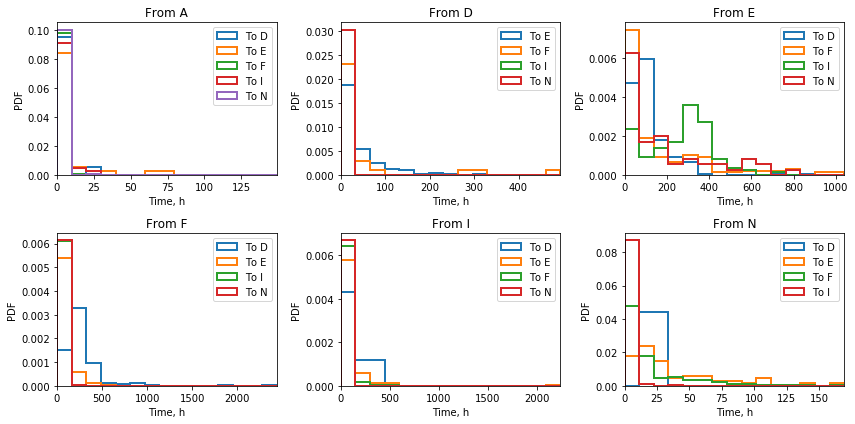

In [11]:
fig = plt.figure(figsize=(3*w, 2*h))
idx = 0
for src, dst, t_range, pp, t_los in ppp:
    plt.subplot('23{0}'.format(idx + 1))
    for di in range(len(dst)):
        plt.hist(t_los[di] / 60, range=(0, lims[idx] / 60), bins=15, 
                 normed=True, label='To ' + dst[di], histtype='step', linewidth=2)
    plt.xlim((0, lims[idx] / 60))
    plt.legend()
    plt.title('From {0}'.format(all_state_index[idx]))
    plt.xlabel('Time, h')
    plt.ylabel('PDF')
    idx += 1
plt.tight_layout()
fig.patch.set_facecolor('white')

### Past transfer
Where has gone at the moment T. Distribution for t<T.

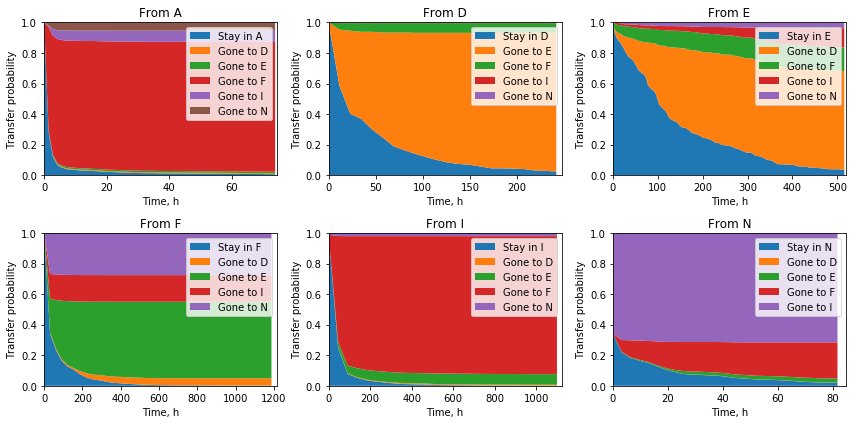

In [12]:
fig = plt.figure(figsize=(3*w, 2*h))
idx = 0
for src, dst, t_range, pp, t_los in ppp:
    plt.subplot('23{0}'.format(idx + 1))
    t_range_cut = t_range[t_range < lims[idx] / 2]
    p_trans = []
    all_cases_count = sum([len(tl) for tl in t_los])
    for t in t_range_cut:
        p_all = [sum(tl <= t) for tl in t_los]
        p_trans.append(np.concatenate(([all_cases_count - sum(p_all)], p_all)) / all_cases_count)
    p_trans = np.array(p_trans)
    p_trans_cumsum = np.cumsum(p_trans, axis=1)
    plt.fill_between(t_range_cut / 60, 0, p_trans[:, 0], label='Stay in ' + all_state_index[idx])
    for i in range(len(dst)):
        plt.fill_between(t_range_cut / 60, p_trans_cumsum[:, i], p_trans_cumsum[:, i+1], 
                         label='Gone to ' + dst[i])
    plt.xlim((0, lims[idx] / 60 / 2))
    plt.ylim((0, 1))
    plt.legend()
    plt.title('From {0}'.format(all_state_index[idx]))
    plt.xlabel('Time, h')
    plt.ylabel('Transfer probability')
    idx += 1
plt.tight_layout()
fig.patch.set_facecolor('white')

# Transfer probabilities by clusters

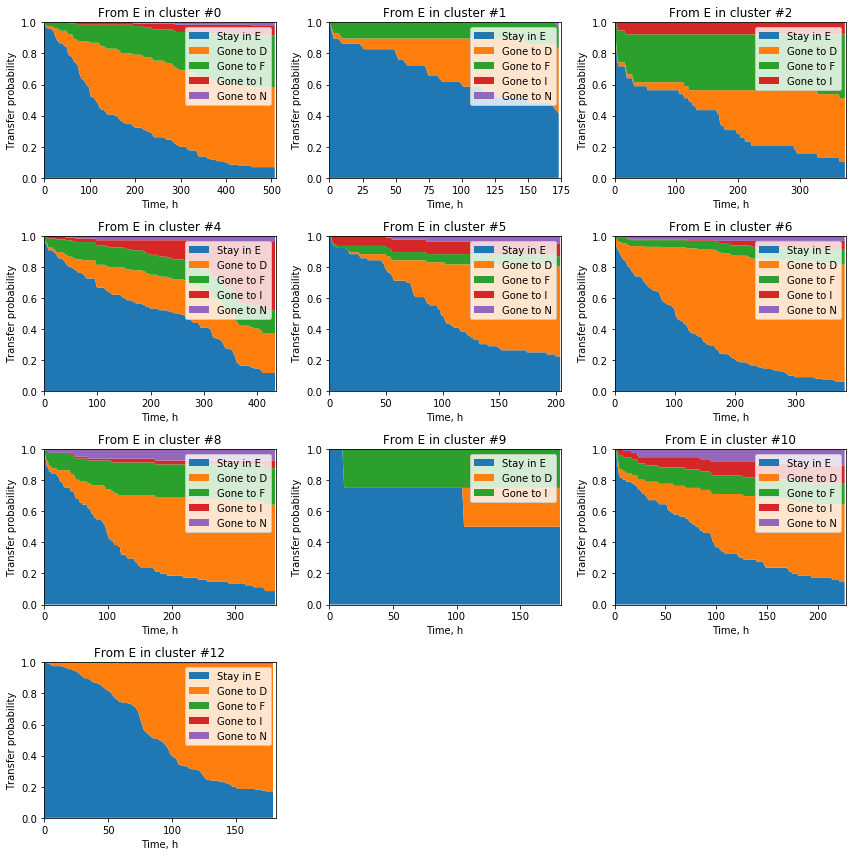

In [34]:
def plot_transitions_by_cluster(from_state):
    state_position = np.min(np.where(all_state_index == from_state))
    fig = plt.figure(figsize=(3*w, 4*h))
    idx = 0
    for cl_i in range(13):
        fname = os.path.join('data', 'transfer_time_and_probs_cluster{0:0>2}.pkl'.format(cl_i))
        if not os.path.exists(fname):
            continue
        with open(fname, 'rb') as f:
            ppp = pickle.load(f)
            src, dst, t_range, pp, t_los = ppp[state_position]        
        plt.subplot(4, 3, idx + 1)
        lims_current = t_range[min(np.max(np.where(pp.max(axis=0) < 0.9999)) + 3, len(t_range) - 1)]
        # lims_current = 800 * 60
        t_range_cut = t_range[t_range < lims_current / 2]
        p_trans = []
        all_cases_count = sum([len(tl) for tl in t_los])
        for t in t_range_cut:
            p_all = [sum(tl <= t) for tl in t_los]
            p_trans.append(np.concatenate(([all_cases_count - sum(p_all)], p_all)) / all_cases_count)
        p_trans = np.array(p_trans)
        p_trans_cumsum = np.cumsum(p_trans, axis=1)
        plt.fill_between(t_range_cut / 60, 0, p_trans[:, 0], label='Stay in ' + src)
        for i in range(len(dst)):
            plt.fill_between(t_range_cut / 60, p_trans_cumsum[:, i], p_trans_cumsum[:, i+1], 
                             label='Gone to ' + dst[i])
        plt.xlim((0, lims_current / 60 / 2))
        plt.ylim((0, 1))
        plt.legend()
        plt.title('From {0} in cluster #{1}'.format(all_state_index[state_position], cl_i))
        plt.xlabel('Time, h')
        plt.ylabel('Transfer probability')
        idx += 1
    plt.tight_layout()
    fig.patch.set_facecolor('white')
plot_transitions_by_cluster('E')

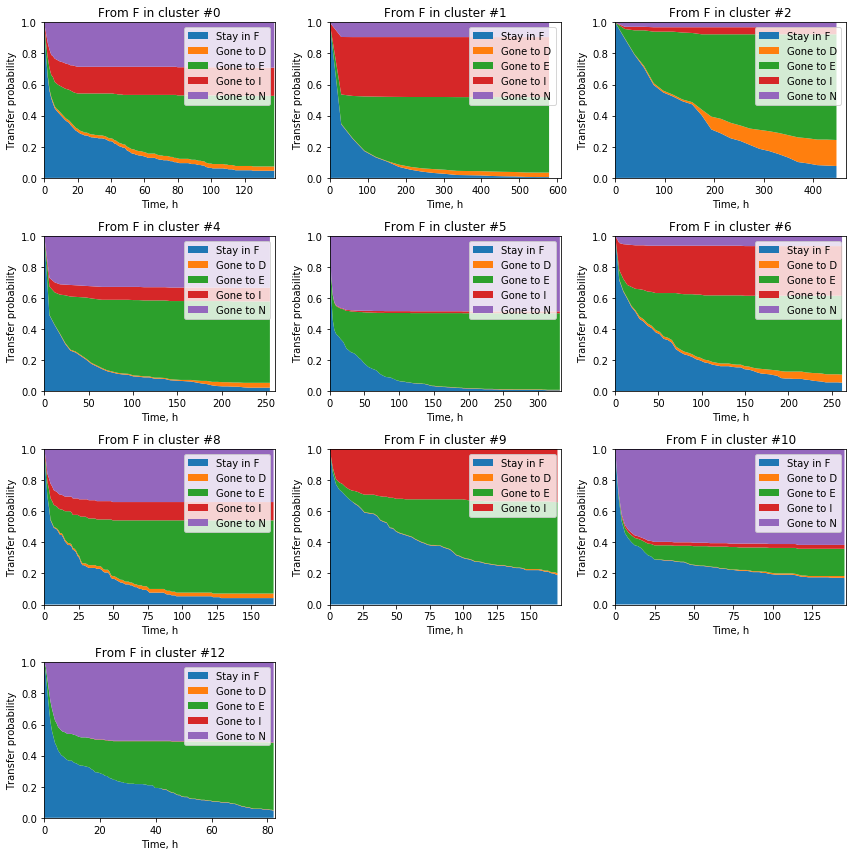

In [35]:
plot_transitions_by_cluster('F')

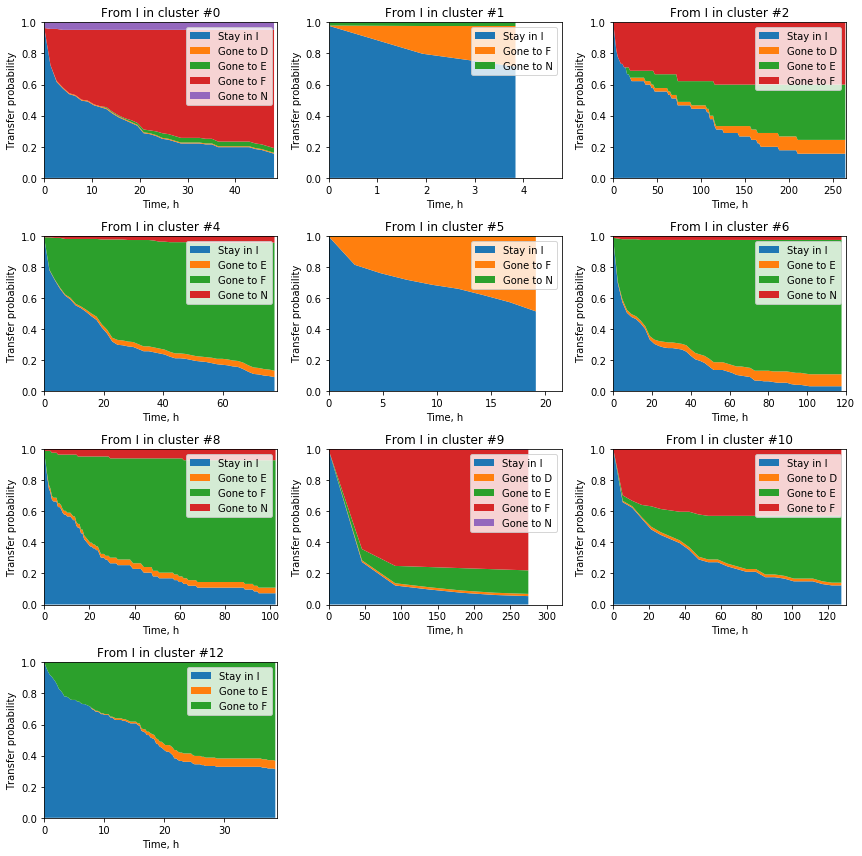

In [37]:
plot_transitions_by_cluster('I')

# TODO
* (!) Estimate class by staying in state or transfer. E state as an example.
* Check transfer probabilities by clusters
* Why time is so large for N and I states